In [2]:
import numpy as np
from collections import defaultdict
import random
from tqdm import trange
import copy
import networkx as nx
import matplotlib.pyplot as plt
import sys
import igraph
from matplotlib import cm, colors
random.seed(42)

In [3]:
class Environment:
    """Abstract Base Class for all environment classes"""
    def __init__(self):
        pass

    def reset(self):
        """
        Reset environment to the start:
          - current_state=1
          - visited_cue=False
        Returns current_state (1).
        """
        pass

    def get_valid_actions(self, state=None):
        """
        Return the list of valid actions for the current state
        (or a given state).
        """
        pass

    def step(self, action):
        """
        Step with a guaranteed valid action. If an invalid action is given,
        we can either ignore or raise an Exception. We'll raise an error.
        """
        pass
    


In [18]:
# Functions for setting up the environment
class GridEnvRightDownNoSelf(Environment):
    """
    A 3x3 grid with states numbered 1..9:

        1   2   3
        4   5   6
        7   8   9

    - The agent can only move RIGHT (0) or DOWN (1).
    - No self-transitions at borders:
        If an action would go out of bounds, that action is not allowed
        from that state.
    - Same cue logic: must visit 5 for a +1 reward at 9, else goes to 10 with -1.
    """

    def __init__(self, cue_states=[2], env_size = (4,4), rewarded_terminal=[16]):
        # Grid layout: (row, col) -> state
        # self.pos_to_state = {
        #     (0,0): 1, (0,1): 2, (0,2): 3, (0,3): 4,
        #     (1,0): 5, (1,1): 6, (1,2): 7, (1,3): 8,
        #     (2,0): 9, (2,1): 10, (2,2): 11, (2,3): 12,
        #     (3,0): 13, (3,1): 14, (3,2): 15, (3,3): 16,
        # }
        self.env_size = env_size
        self.pos_to_state = {}        
        state = 0
        for i in range(self.env_size[0]):
            for j in range(self.env_size[1]):
                state += 1
                self.pos_to_state[(i,j)] = state
                
        
        self.state_to_pos = {s: rc for rc, s in self.pos_to_state.items()}

        self.rewarded_terminals = rewarded_terminal
        # self.unrewarded_terminals = self.rewarded_terminals+1  # not in the grid, just a label
        self.unrewarded_terminals = [s+state+1 for s in range(len(self.rewarded_terminals))]        
        
        # Actions as integers: 0=right, 1=down
        # right => (0, +1)
        # down  => (+1, 0)
        self.base_actions = {
            0: (0, +1),   # right
            1: (+1, 0)    # down
        }
        
        # Instead of having a static [0,1] action space, we have a
        # per-state action set (no invalid moves).
        self.valid_actions = self._build_valid_actions()

        # Special states
        self.start_state = 1
        self.cue_state = cue_states

        
        
        
        self.num_unique_states = state + len(self.unrewarded_terminals) # hard coded for now # done!
        self.reset()

    def _build_valid_actions(self):
        """
        Precompute valid actions for each non-terminal grid state.
        A 'valid' action is one that leads to a NEW in-bounds state.
        """
        valid_dict = {}
        for row in range(self.env_size[0]):
            for col in range(self.env_size[1]):
                s = self.pos_to_state[(row, col)]
                # We'll store all actions that yield a different state (no self-transitions)
                valid_dict[s] = []
                for a, (dr, dc) in self.base_actions.items():
                    new_r = row + dr
                    new_c = col + dc
                    if 0 <= new_r < self.env_size[0] and 0 <= new_c < self.env_size[1]:
                        next_s = self.pos_to_state[(new_r, new_c)]
                        # Only count it if next_s != s (which can't happen in 3x3, but let's be explicit)
                        if next_s != s:
                            valid_dict[s].append(a)

        # For terminal states 9 and 10, no actions are valid
        # valid_dict[9] = []
        # valid_dict[10] = []
        # valid_dict[16] = []
        # valid_dict[17] = []
        
        # For terminal states, no actions are valid
        for terminals in self.rewarded_terminals:
            valid_dict[terminals] = []
        for terminals in self.unrewarded_terminals:
            valid_dict[terminals] = []

        return valid_dict

    def reset(self):
        """
        Reset environment to the start:
          - current_state=1
          - visited_cue=False
        Returns current_state (1).
        """
        self.current_state = self.start_state
        self.visited_cue = False
        return self.current_state

    def get_valid_actions(self, state=None):
        """
        Return the list of valid actions for the current state
        (or a given state).
        """
        if state is None:
            state = self.current_state
        return self.valid_actions[state]

    def step(self, action):
        """
        Step with a guaranteed valid action. If an invalid action is given,
        we can either ignore or raise an Exception. We'll raise an error.
        """
        if action not in self.get_valid_actions():
            raise ValueError(f"Action {action} is not valid from state {self.current_state}.")

        # If we're already in a terminal (9 or 10), episode is over.
        if self.current_state in [self.rewarded_terminals, self.unrewarded_terminals]:
            return self.current_state, 0, True

        # Move
        row, col = self.state_to_pos[self.current_state]
        dr, dc = self.base_actions[action]
        next_row = row + dr
        next_col = col + dc

        next_state = self.pos_to_state[(next_row, next_col)]

        # Check cue
        if next_state in self.cue_state:
            self.visited_cue = True

        reward = 0
        done = False

        # Terminal condition: 8 -> 9
        # if next_state == 16:
        if next_state in self.rewarded_terminals:    
            done = True
            if self.visited_cue:
                reward = +1
                # next_state = self.rewarded_terminal
            else:
                reward = -1
                idx = self.rewarded_terminals.index(next_state)
                next_state = self.unrewarded_terminals[idx]
                # next_state = self.unrewarded_terminal


        # Update
        self.current_state = next_state
        return next_state, reward, done
    
class GridEnvRightDownNoCue(Environment):
    """
    A 3x3 grid with states numbered 1..9:

        1   2   3
        4   5   6
        7   8   9

    - The agent can only move RIGHT (0) or DOWN (1).
    - No self-transitions at borders:
        If an action would go out of bounds, that action is not allowed
        from that state.
    - Same cue logic: must visit 5 for a +1 reward at 9, else goes to 10 with -1.
    """

    def __init__(self):
        # Grid layout: (row, col) -> state
        self.pos_to_state = {
            (0,0): 1, (0,1): 2, (0,2): 3, (0,3): 4,
            (1,0): 5, (1,1): 6, (1,2): 7, (1,3): 8,
            (2,0): 9, (2,1): 10, (2,2): 11, (2,3): 12,
            (3,0): 13, (3,1): 14, (3,2): 15, (3,3): 16,
        }
        self.state_to_pos = {s: rc for rc, s in self.pos_to_state.items()}
        
        # Actions as integers: 0=right, 1=down
        # right => (0, +1)
        # down  => (+1, 0)
        self.base_actions = {
            0: (0, +1),   # right
            1: (+1, 0)    # down
        }
        
        # Instead of having a static [0,1] action space, we have a
        # per-state action set (no invalid moves).
        self.valid_actions = self._build_valid_actions()

        # Special states
        self.start_state = 1
        # self.cue_state = cue_state
        self.rewarded_terminal = 16
        self.unrewarded_terminal = 17  # not in the grid, just a label

        self.reset()

    def _build_valid_actions(self):
        """
        Precompute valid actions for each non-terminal grid state.
        A 'valid' action is one that leads to a NEW in-bounds state.
        """
        valid_dict = {}
        for row in range(4):
            for col in range(4):
                s = self.pos_to_state[(row, col)]
                # We'll store all actions that yield a different state (no self-transitions)
                valid_dict[s] = []
                for a, (dr, dc) in self.base_actions.items():
                    new_r = row + dr
                    new_c = col + dc
                    if 0 <= new_r < 4 and 0 <= new_c < 4:
                        next_s = self.pos_to_state[(new_r, new_c)]
                        # Only count it if next_s != s (which can't happen in 3x3, but let's be explicit)
                        if next_s != s:
                            valid_dict[s].append(a)

        # For terminal states 9 and 10, no actions are valid
        # valid_dict[9] = []
        # valid_dict[10] = []
        valid_dict[16] = []
        valid_dict[17] = []

        return valid_dict

    def reset(self):
        """
        Reset environment to the start:
          - current_state=1
          - visited_cue=False
        Returns current_state (1).
        """
        self.current_state = self.start_state
        self.visited_cue = False
        return self.current_state

    def get_valid_actions(self, state=None):
        """
        Return the list of valid actions for the current state
        (or a given state).
        """
        if state is None:
            state = self.current_state
        return self.valid_actions[state]

    def step(self, action):
        """
        Step with a guaranteed valid action. If an invalid action is given,
        we can either ignore or raise an Exception. We'll raise an error.
        """
        if action not in self.get_valid_actions():
            raise ValueError(f"Action {action} is not valid from state {self.current_state}.")

        # If we're already in a terminal (9 or 10), episode is over.
        if self.current_state in [self.rewarded_terminal, self.unrewarded_terminal]:
            return self.current_state, 0, True

        # Move
        row, col = self.state_to_pos[self.current_state]
        dr, dc = self.base_actions[action]
        next_row = row + dr
        next_col = col + dc

        next_state = self.pos_to_state[(next_row, next_col)]
        
        # if self.current_state == 15
        # if next_state == 16:


        # Check cue
        # if next_state == self.cue_state:
        #     self.visited_cue = True

        reward = 0
        done = False

        # Terminal condition: 8 -> 9
        if next_state == 16:
            done = True
            # if self.visited_cue:
                # reward = +1
            if np.random.rand() < 0.5:
                next_state = self.unrewarded_terminal
            else: 
                # next_state=17       
                next_state = self.rewarded_terminal
            # else:
                # reward = -1
                

        # Update
        self.current_state = next_state
        return next_state, reward, done
    
    # Create the graph
    def plot_graph(self, T, niter, 
                #    reward_terminal = [16], env_size = (4,4),
                   highlight_node=-1, highlight_node_2 = -1,
                   save=True,savename='img'):
        G = nx.DiGraph()
        n_state = np.shape(T)[0]
        n_action = np.shape(T)[1]
        # Add nodes
        for s in range(n_state-1):
            G.add_node(s+1)

        # Add edges with color coding for each action (optional)
        edge_colors = []
        for s in range(n_state):
            for a in range(n_action):  # actions 0 or 1
                for s_next in range(n_state):
                    prob = T[s, a, s_next]
                    if prob > 0:
                        # Add a directed edge from s to s_next
                        # Label with a=0 or a=1, or probability, or both
                        G.add_edge(s, s_next, label=f"A{a}, p={prob:.1f}")
                        
                        # (Optional) color edges differently for each action
                        if a == 0:  
                            edge_colors.append("blue")   # right edges in blue
                        else:
                            edge_colors.append("green")  # down edges in green

        # Build position dictionary
        pos = {}
        horizontal_scale = 3
        vertical_scale = 3
        offset = 0.2
        for s in range(n_state):
            row = s // self.env_size[0] #4
            col = s % self.env_size[1] #4
            pos[s+1] = (col * horizontal_scale, -row * vertical_scale)
            if s in self.unrewarded_terminal: 
                # if s==17: 
                # pos[s] = (pos[16][0]+offset, pos[16][1] + offset)
                idx = self.rewarded_terminal.index(s)
                pos[s] = (pos[idx][0]+offset, pos[idx][1] + offset)
            elif s > self.num_unique_states:
            # elif s > 17: 
                pos[s] = (pos[clone_dict[s]][0]+offset, pos[clone_dict[s]][1]+offset)

        plt.figure(figsize=(12,8))
        # Create a color list; default 'lightblue', but 'red' for special_node
        colors = []
        for node in G.nodes():
            if node == highlight_node:
                colors.append("red")
            elif node == highlight_node_2:
                colors.append("yellow")
            else:
                colors.append("lightblue")
        
        # nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1200)
        nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=1200)
        nx.draw_networkx_labels(G, pos, font_size=20, font_color='black')

        # We need to extract edges in the same order they were added 
        # so that edge_colors aligns properly
        edges = list(G.edges())
        nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors,
                            arrowstyle='->', arrowsize=20, width=3)
        nx.draw_networkx_edge_labels(G, pos, 
                                    edge_labels=nx.get_edge_attributes(G, 'label'),
                                    font_size=10, label_pos=0.5)

        plt.axis('off')
        plt.title("Graph at iteration {}".format(niter), size=20)
        plt.tight_layout()
    
        savename = savename+"_iteration_" + str(niter)
        if save: 
            plt.savefig(savename)
        plt.show()    
    
        
def generate_dataset(env, n_episodes=10, max_steps=20):
    """
    Run 'n_episodes' episodes in the environment. Each episode ends
    either when the environment signals 'done' or when we hit 'max_steps'.

    Returns:
        A list of (state_sequence, action_sequence) pairs.
        - state_sequence: list of visited states
        - action_sequence: list of chosen actions
    """
    dataset = []

    for episode_idx in range(n_episodes):
        # Prepare lists to store states & actions for this episode
        states = []
        actions = []

        # Reset env to start a new episode
        state = env.reset()

        for t in range(max_steps):
            states.append(state)

            valid_actions = env.get_valid_actions(state)
            if not valid_actions:
                # No valid actions => we must be in a terminal or stuck
                break

            # Example: pick a random valid action
            action = np.random.choice(valid_actions)
            actions.append(action)

            # Step in the environment
            next_state, reward, done = env.step(action)
            state = next_state

            if done:
                # Also record the final state
                states.append(state)

                if state == 16:
                    print(f"rewarded path: {states}")
                break
                
        # Store (states, actions) for this episode
        dataset.append([states, actions])

    return dataset
def TM(dataset):
    """
    Given a dataset of episodes, each episode being (states_seq, actions_seq),
    build a 3D count matrix of shape [max_state+1, max_action+1, max_state+1].
    
    Returns:
        transition_counts (np.ndarray): counts[s, a, s_next]
            The number of times we observed (state=s) --(action=a)--> (next_state=s_next).
    """
    # 1) Collect all observed states and actions to determine indexing bounds
    all_states = set()
    all_actions = set()
    
    for states_seq, actions_seq in dataset:
        for s in states_seq:
            all_states.add(s)
        for a in actions_seq:
            all_actions.add(a)
    
    max_state = max(all_states) if all_states else 0
    max_action = max(all_actions) if all_actions else 0
    
    # 2) Initialize a 3D count array
    #    We'll assume states range from 0..max_state
    #    and actions range from 0..max_action
    transition_counts = np.zeros((max_state+1, max_action+1, max_state+1), dtype=int)
    
    # 3) Fill in the counts by iterating over each episode's transitions
    for states_seq, actions_seq in dataset:
        # for each step t in the episode
        for t in range(len(actions_seq)):
            s = states_seq[t]
            a = actions_seq[t]
            s_next = states_seq[t+1]
            transition_counts[s, a, s_next] += 1
    
    return transition_counts
def compute_transition_entropies(transition_probs, tol=1e-9):
    """
    Given transition_probs[s, a, s_next], compute the Shannon entropy
    (in bits, i.e. log base 2) of each (s, a) distribution.
    
    Returns:
        entropies: A 2D array of shape [S, A], where entropies[s, a]
                   is the entropy of transition_probs[s, a, :].
    
    Notes:
      - If the total probability mass for (s, a) is ~0 (i.e. no data),
        we set entropy to 0 by default (or you could mark it as NaN).
      - We ignore states that are purely out-of-bounds or never visited.
    """
    S, A, _ = transition_probs.shape
    entropies = np.zeros((S, A), dtype=float)
    
    for s in range(S):
        for a in range(A):
            dist = transition_probs[s, a]  # shape = [S]
            
            # Sum of probabilities (should be ~1 if we have data)
            total_prob = dist.sum()
            if total_prob < tol:
                # Means no data or zero-prob distribution
                entropies[s, a] = 0.0
                continue
            
            # Identify the non-zero probabilities (to avoid log(0))
            p_nonzero = dist[dist > tol]
            
            # Normalize them so they sum to 1
            p_nonzero /= p_nonzero.sum()
            
            # Shannon entropy in bits
            #  E = - sum(p * log2(p))
            ent = -np.sum(p_nonzero * np.log2(p_nonzero))
            entropies[s, a] = ent
            
    return entropies

def find_stochastic_state_actions_by_entropy(entropies, eps=1e-9):
    """
    Given a 2D array of entropies[s,a], return a list of (s,a) pairs
    that are strictly > eps in entropy (i.e. non-deterministic).
    """
    stochastic_pairs = []
    S, A = entropies.shape
    for s in range(S):
        for a in range(A):
            # If entropy is basically 0 => deterministic
            if entropies[s, a] > eps:
                stochastic_pairs.append((s,a))
    return stochastic_pairs


In [47]:
class GridEnvDivergingSingleReward(Environment):
    """
    A 3x3 grid with states numbered 1..9:

        1   2   3
        4   5   6
        7   8   9

    - The agent can only move RIGHT (0) or DOWN (1).
    - No self-transitions at borders:
        If an action would go out of bounds, that action is not allowed
        from that state.
    - Same cue logic: must visit 5 for a +1 reward at 9, else goes to 10 with -1.
    """

    def __init__(self, cue_state=2):
        # Grid layout: (row, col) -> state
        self.pos_to_state = {
            (0,0): 1, (0,1): 2, (0,2): 3, (0,3): 4,
            (1,0): 5, (1,1): 6, (1,2): 7, (1,3): 8,
            (2,0): 9, (2,1): 10, (2,2): 11, (2,3): 12,
            (3,0): 13, (3,1): 14, (3,2): 15, (3,3): 16,
        }
        self.state_to_pos = {s: rc for rc, s in self.pos_to_state.items()}

        self.num_unique_states = 17 # hard coded for now
        
        # Actions as integers: 0=right, 1=down
        # right => (0, +1)
        # down  => (+1, 0)
        self.base_actions = {
            0: (0, +1),   # right
            1: (+1, 0)    # down
        }

        # Special states
        self.start_state = 1
        self.cue_state = cue_state
        self.rewarded_terminal = 16  # not in grid but it is being treated as a reward - flipped from previous for simplicity
        self.terminal_states = {4, 8, 12, 16, 17}
        
        # Instead of having a static [0,1] action space, we have a
        # per-state action set (no invalid moves).
        self.valid_actions = self._build_valid_actions()

        self.reset()

    def _build_valid_actions(self):
        """
        Precompute valid actions for each non-terminal grid state.
        A 'valid' action is one that leads to a NEW in-bounds state.
        """
        valid_dict = {}
        for row in range(4):
            for col in range(4):
                s = self.pos_to_state[(row, col)]
                # We'll store all actions that yield a different state (no self-transitions)
                valid_dict[s] = []
                for a, (dr, dc) in self.base_actions.items():
                    new_r = row + dr
                    new_c = col + dc
                    if 0 <= new_r < 4 and 0 <= new_c < 4:
                        next_s = self.pos_to_state[(new_r, new_c)]
                        # Only count it if next_s != s (which can't happen in 3x3, but let's be explicit)
                        if next_s != s:
                            valid_dict[s].append(a)

        
        # Terminal states have no valid actions
        for terminal in self.terminal_states:
            valid_dict[terminal] = []
        return valid_dict

    def reset(self):
        """
        Reset environment to the start:
          - current_state=1
          - visited_cue=False
        Returns current_state (1).
        """
        self.current_state = self.start_state
        self.visited_cue = False
        return self.current_state

    def get_valid_actions(self, state=None):
        """
        Return the list of valid actions for the current state
        (or a given state).
        """
        if state is None:
            state = self.current_state
        return self.valid_actions[state]

    def step(self, action):
        """
        Step with a guaranteed valid action. If an invalid action is given,
        we can either ignore or raise an Exception. We'll raise an error.
        """
        if action not in self.get_valid_actions():
            raise ValueError(f"Action {action} is not valid from state {self.current_state}.")

        # If we're already in a terminal (9 or 10), episode is over.
        if self.current_state in self.terminal_states:
            return self.current_state, 0, True

        # Move
        row, col = self.state_to_pos[self.current_state]
        dr, dc = self.base_actions[action]
        next_row = row + dr
        next_col = col + dc

        next_state = self.pos_to_state[(next_row, next_col)]

        # Check cue
        if next_state == self.cue_state:
            self.visited_cue = True

        reward = 0
        done = next_state in self.terminal_states

        if done:
            if self.visited_cue and next_state == 16:  # only reward if the cue has been visited and the right terminal state is visited
                reward = +1
                next_state = self.rewarded_terminal
            else:
                reward = -1
                next_state = 17

        # Update
        self.current_state = next_state
        return next_state, reward, done
    

class GridEnvDivergingMultipleReward(Environment):
    """
    A 3x3 grid with states numbered 1..9:

        1   2   3
        4   5   6
        7   8   9

    - The agent can only move RIGHT (0) or DOWN (1).
    - No self-transitions at borders:
        If an action would go out of bounds, that action is not allowed
        from that state.
    - Same cue logic: must visit 5 for a +1 reward at 9, else goes to 10 with -1.
    """

    def __init__(self, cue_state=2):
        # Grid layout: (row, col) -> state
        self.pos_to_state = {
            (0,0): 1, (0,1): 2, (0,2): 3, (0,3): 4,
            (1,0): 5, (1,1): 6, (1,2): 7, (1,3): 8,
            (2,0): 9, (2,1): 10, (2,2): 11, (2,3): 12,
            (3,0): 13, (3,1): 14, (3,2): 15, (3,3): 16,
        }

        self.state_to_pos = {s: rc for rc, s in self.pos_to_state.items()}
        
        # Actions as integers: 0=right, 1=down
        # right => (0, +1)
        # down  => (+1, 0)
        self.base_actions = {
            0: (0, +1),   # right
            1: (+1, 0)    # down
        }
        
        # Instead of having a static [0,1] action space, we have a
        # per-state action set (no invalid moves).
        self.valid_actions = self._build_valid_actions()

        # Special states
        self.start_state = 1
        self.cue_state = cue_state
        self.rewarded_terminal = 16 
        self.terminal_states = {4, 8, 12, 16, 17}

        self.current_state = self.start_state
        self.visited_cue = False

    def _build_valid_actions(self):
        """
        Precompute valid actions for each non-terminal grid state.
        A 'valid' action is one that leads to a NEW in-bounds state.
        """
        valid_dict = {}
        for row in range(4):
            for col in range(4):
                s = self.pos_to_state[(row, col)]
                # We'll store all actions that yield a different state (no self-transitions)
                valid_dict[s] = []
                for a, (dr, dc) in self.base_actions.items():
                    new_r = row + dr
                    new_c = col + dc
                    if 0 <= new_r < 4 and 0 <= new_c < 4:
                        next_s = self.pos_to_state[(new_r, new_c)]
                        # Only count it if next_s != s (which can't happen in 3x3, but let's be explicit)
                        if next_s != s:
                            valid_dict[s].append(a)

        # For terminal states 9 and 10, no actions are valid
        # valid_dict[9] = []
        # valid_dict[10] = []
        valid_dict[16] = []
        valid_dict[17] = []

        return valid_dict

    def reset(self):
        """
        Reset environment to the start:
          - current_state=1
          - visited_cue=False
        Returns current_state (1).
        """
        self.current_state = self.start_state
        self.visited_cue = False
        return self.current_state

    def get_valid_actions(self, state=None):
        """
        Return the list of valid actions for the current state
        (or a given state).
        """
        if state is None:
            state = self.current_state
        return self.valid_actions[state]

    def step(self, action):
        """
        Step with a guaranteed valid action. If an invalid action is given,
        we can either ignore or raise an Exception. We'll raise an error.
        """
        if action not in self.get_valid_actions():
            raise ValueError(f"Action {action} is not valid from state {self.current_state}.")

        # If we're already in a terminal (9 or 10), episode is over.
        if self.current_state in self.terminal_states:
            return self.current_state, 0, True

        # Move
        row, col = self.state_to_pos[self.current_state]
        dr, dc = self.base_actions[action]
        next_row = row + dr
        next_col = col + dc

        next_state = self.pos_to_state[(next_row, next_col)]

        # Check cue
        if next_state == self.cue_state:
            self.visited_cue = True

        reward = 0
        done = False

        # Terminal condition: 8 -> 9

        reward = 0
        done = next_state in self.terminal_states

        if done:
            if self.visited_cue:  # only reward if the cue has been visited and the right terminal state is visited
                reward = +1
                next_state = self.rewarded_terminal  # set all the rewards to 16 - for simplicity sake
            else:
                reward = -1
                next_state = 17

        # Update
        self.current_state = next_state
        return next_state, reward, done

In [6]:
# Functions for contingency & splitting

def get_unique_states(dataset):
    all_states = []
    for states_seq, _ in dataset:
        all_states.extend(states_seq)  # Flatten the list
    unique_states = np.unique(all_states)
    return unique_states

def get_unique_states_from_env(env):
    return [x for x in env.pos_to_state.values()]

def has_state(sequence, state):
    """Return True if the episode's state sequence contains state=5."""
    return state in sequence

def has_transition(s,sprime,sequence):
    """Return True if the episode's state sequence contains a transition 15->16."""
    for i in range(len(sequence) - 1):
        if sequence[i] == s and sequence[i + 1] == sprime:
            return True
    return False

# s=12
# sprime=16
# sprime2 = 17
def calculate_contingency(dataset, s, sprime, sprime2):
    unique_states = get_unique_states(dataset)
    contingency_states = []
    for curr_state in unique_states:
        # if curr_state<100:
        if (curr_state < s or curr_state > 17):    # maybe here
            # print(curr_state)
            # episodes_with_state = 0
            # episodes_with_state_and_transition = 0
            # other =0
            # curr_state = 6

            total = 0
            a=0
            b=0
            c=0
            d=0
            conditioned_contingency=0
            # print("Current state: {}".format(curr_state))
            for states_seq, actions_seq in dataset:
                if has_state(states_seq,s):
                    total += 1
                    if has_state(states_seq, curr_state):
                    
                        
                        # episodes_with_state += 1
                        if has_transition(s,sprime,states_seq): 
                            # episodes_with_state_and_transition += 1   
                            a += 1
                            # if curr_state==18:
                            #     print('a:')
                            #     print(states_seq)
                            # print('transition: {}'.format(states_seq))
                        elif has_transition(s,sprime2, states_seq): 
                            # print(states_seq)
                            b+=1
                            # if curr_state==18:
                            #     print('b:')
                            #     print(states_seq)
                    else: 
                        # print('here')
                        if has_transition(s,sprime,states_seq): 
                            # episodes_with_state_and_transition += 1   
                            c += 1
                            # if curr_state==18:
                            #     print('c:')
                            #     print(states_seq)                            
                            
                            # print('transition: {}'.format(states_seq))
                        elif has_transition(s,sprime2, states_seq): 
                            # print(states_seq)
                            d+=1
                            # if curr_state==18:
                            #     print('d:')
                            #     print(states_seq)                            
                    assert total == a+b+c+d
            # if curr_state == 18: 
            #     print(a/(a+b), d/(c+d))
            #     print(a,b,c,d)
            # if a+b != 0: 
            #     print("forward contingency: {}".format(a/(a+b)))
            # else: 
            #     print("no forward contingency")
            # if c+d != 0: 
            #     print("backward contingency: {}".format(d/(c+d)))
            # else: 
            #     print("no backward contingency")
            if a+b !=0 and c+d != 0: 
                # if (a/(a+b)==1 and d/(c+d)==1):
                if a/(a+b)==1: # and d/(c+d)==1):
                    
                    contingency_states.append(curr_state)
        print(f"state {curr_state} has a value {a} and b value {b} leading to a/(a+b) = {a/(a+b) if a+b != 0 else -1}")
    print(f"contigency states: {contingency_states}")
    return contingency_states

def calculate_contingency_tmaze(dataset, s, sprime, sprime2):
    unique_states = get_unique_states(dataset)
    contingency_states = []
    for curr_state in unique_states:
        # if curr_state<100:
        # if (curr_state < s or curr_state > 17):
            # print(curr_state)
            # episodes_with_state = 0
            # episodes_with_state_and_transition = 0
            # other =0
            # curr_state = 6

        total = 0
        a=0
        b=0
        c=0
        d=0
        conditioned_contingency=0
        # print("Current state: {}".format(curr_state))
        for states_seq, actions_seq in dataset:
            if has_state(states_seq,s):
                total += 1
                if has_state(states_seq, curr_state):
                
                    
                    # episodes_with_state += 1
                    if has_transition(s,sprime,states_seq): 
                        # episodes_with_state_and_transition += 1   
                        a += 1
                        # if curr_state==18:
                        #     print('a:')
                        #     print(states_seq)
                        # print('transition: {}'.format(states_seq))
                    elif has_transition(s,sprime2, states_seq): 
                        # print(states_seq)
                        b+=1
                        # if curr_state==18:
                        #     print('b:')
                        #     print(states_seq)
                else: 
                    # print('here')
                    if has_transition(s,sprime,states_seq): 
                        # episodes_with_state_and_transition += 1   
                        c += 1
                        # if curr_state==18:
                        #     print('c:')
                        #     print(states_seq)                            
                        
                        # print('transition: {}'.format(states_seq))
                    elif has_transition(s,sprime2, states_seq): 
                        # print(states_seq)
                        d+=1
                        # if curr_state==18:
                        #     print('d:')
                        #     print(states_seq)                            
                # assert total == a+b+c+d
        # if curr_state == 18: 
        #     print(a/(a+b), d/(c+d))
        #     print(a,b,c,d)
        # if a+b != 0: 
        #     print("forward contingency: {}".format(a/(a+b)))
        # else: 
        #     print("no forward contingency")
        # if c+d != 0: 
        #     print("backward contingency: {}".format(d/(c+d)))
        # else: 
        #     print("no backward contingency")
        if a+b !=0 and c+d != 0: 
            # if (a/(a+b)==1 and d/(c+d)==1):
            if a/(a+b)==1: # and d/(c+d)==1):
                
                contingency_states.append(curr_state)

    return contingency_states

                
def get_successor_states(transition_counts,s,a):
    next_states = transition_counts[s,a]
    sprime = np.where(next_states!=0)[0]
    return sprime

In [8]:
# Function for plotting graph



# # Create the graph
# def plot_graph(T, niter, reward_terminal = [16], env_size = (4,4),highlight_node=-1, highlight_node_2 = -1,save=True,savename='img'):
#     G = nx.DiGraph()
#     n_state = np.shape(T)[0]
#     n_action = np.shape(T)[1]
#     # Add nodes
#     for s in range(n_state-1):
#         G.add_node(s+1)

#     # Add edges with color coding for each action (optional)
#     edge_colors = []
#     for s in range(n_state):
#         for a in range(n_action):  # actions 0 or 1
#             for s_next in range(n_state):
#                 prob = T[s, a, s_next]
#                 if prob > 0:
#                     # Add a directed edge from s to s_next
#                     # Label with a=0 or a=1, or probability, or both
#                     G.add_edge(s, s_next, label=f"A{a}, p={prob:.1f}")
                    
#                     # (Optional) color edges differently for each action
#                     if a == 0:  
#                         edge_colors.append("blue")   # right edges in blue
#                     else:
#                         edge_colors.append("green")  # down edges in green

#     # Build position dictionary
#     pos = {}
#     horizontal_scale = 3
#     vertical_scale = 3
#     offset = 0.2
#     for s in range(n_state):
#         row = s // env_size[0] #4
#         col = s % env_size[1] #4
#         pos[s+1] = (col * horizontal_scale, -row * vertical_scale)
#         if 
#         if s==17: 
#             pos[s] = (pos[16][0]+offset, pos[16][1] + offset)
#         elif s > 17: 
#             pos[s] = (pos[clone_dict[s]][0]+offset, pos[clone_dict[s]][1]+offset)

#     plt.figure(figsize=(12,8))
#     # Create a color list; default 'lightblue', but 'red' for special_node
#     colors = []
#     for node in G.nodes():
#         if node == highlight_node:
#             colors.append("red")
#         elif node == highlight_node_2:
#             colors.append("yellow")
#         else:
#             colors.append("lightblue")
    
#     # nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1200)
#     nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=1200)
#     nx.draw_networkx_labels(G, pos, font_size=20, font_color='black')

#     # We need to extract edges in the same order they were added 
#     # so that edge_colors aligns properly
#     edges = list(G.edges())
#     nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=edge_colors,
#                         arrowstyle='->', arrowsize=20, width=3)
#     nx.draw_networkx_edge_labels(G, pos, 
#                                 edge_labels=nx.get_edge_attributes(G, 'label'),
#                                 font_size=10, label_pos=0.5)

#     plt.axis('off')
#     plt.title("Graph at iteration {}".format(niter), size=20)
#     plt.tight_layout()
   
#     savename = savename+"_iteration_" + str(niter)
#     if save: 
#         plt.savefig(savename)
#     plt.show()
# # plot_graph(transition_probs,10)


rewarded path: [1, 5, 6, 7, 8, 12, 16]
rewarded path: [1, 2, 6, 7, 8, 12, 16]
rewarded path: [1, 2, 3, 7, 8, 12, 16]
rewarded path: [1, 2, 6, 10, 14, 15, 16]
rewarded path: [1, 2, 3, 4, 8, 12, 16]
rewarded path: [1, 2, 3, 7, 8, 12, 16]
rewarded path: [1, 2, 6, 7, 11, 15, 16]
rewarded path: [1, 2, 6, 10, 11, 15, 16]
rewarded path: [1, 2, 6, 7, 8, 12, 16]
rewarded path: [1, 5, 6, 10, 14, 15, 16]
rewarded path: [1, 5, 6, 7, 8, 12, 16]
rewarded path: [1, 2, 6, 10, 11, 12, 16]
rewarded path: [1, 2, 3, 7, 8, 12, 16]
rewarded path: [1, 2, 3, 4, 8, 12, 16]
rewarded path: [1, 2, 6, 7, 8, 12, 16]
rewarded path: [1, 2, 3, 4, 8, 12, 16]
rewarded path: [1, 2, 6, 7, 11, 12, 16]
rewarded path: [1, 2, 6, 7, 11, 15, 16]
rewarded path: [1, 2, 3, 4, 8, 12, 16]
rewarded path: [1, 2, 6, 7, 11, 15, 16]
rewarded path: [1, 5, 6, 7, 11, 12, 16]
rewarded path: [1, 5, 6, 7, 11, 12, 16]
rewarded path: [1, 5, 6, 7, 11, 15, 16]
rewarded path: [1, 5, 6, 10, 14, 15, 16]
rewarded path: [1, 2, 6, 10, 11, 12, 16]
reward

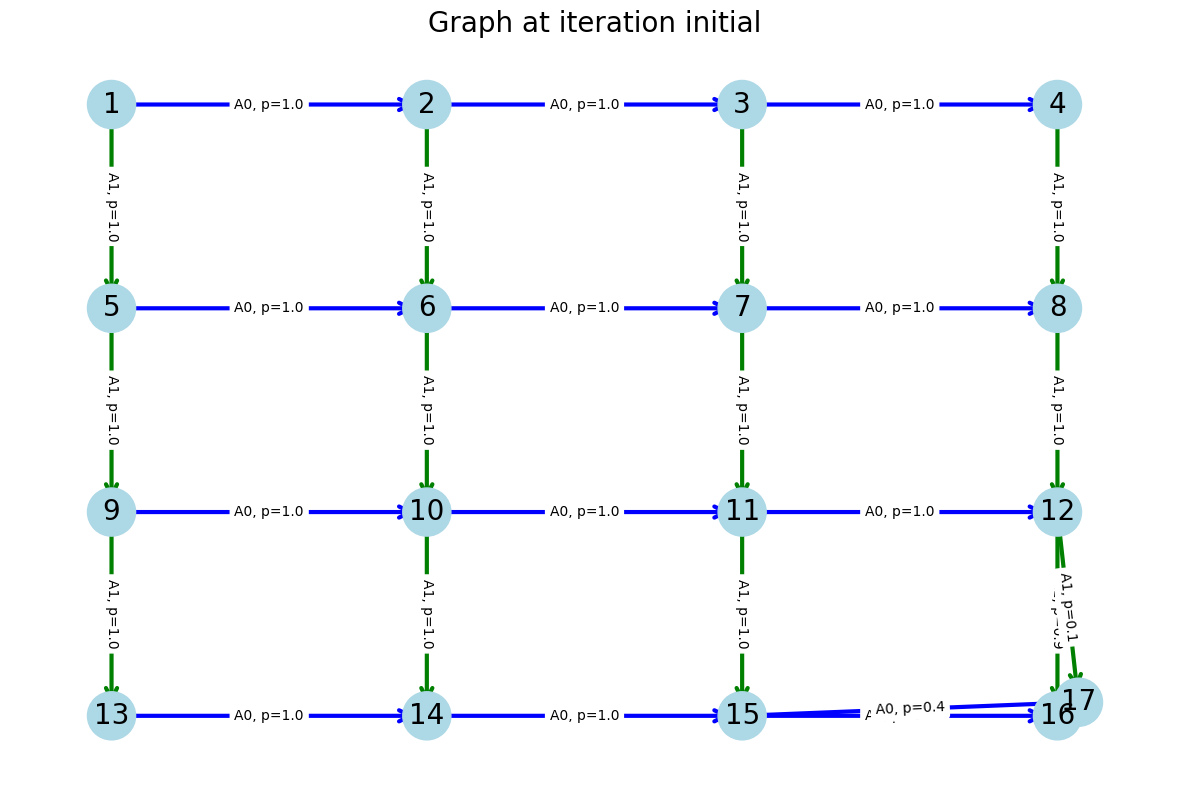

Iteration 0
Stochastic pairs: (12, 1)
state 1 has a value 229 and b value 15 leading to a/(a+b) = 0.9385245901639344
state 2 has a value 159 and b value 0 leading to a/(a+b) = 1.0
state 3 has a value 97 and b value 0 leading to a/(a+b) = 1.0
state 4 has a value 63 and b value 0 leading to a/(a+b) = 1.0
state 5 has a value 70 and b value 15 leading to a/(a+b) = 0.8235294117647058
state 6 has a value 132 and b value 0 leading to a/(a+b) = 1.0
state 7 has a value 138 and b value 0 leading to a/(a+b) = 1.0
state 8 has a value 159 and b value 0 leading to a/(a+b) = 1.0
state 9 has a value 0 and b value 15 leading to a/(a+b) = 0.0
state 10 has a value 28 and b value 15 leading to a/(a+b) = 0.6511627906976745
state 11 has a value 70 and b value 15 leading to a/(a+b) = 0.8235294117647058
state 12 has a value 70 and b value 15 leading to a/(a+b) = 0.8235294117647058
state 13 has a value 70 and b value 15 leading to a/(a+b) = 0.8235294117647058
state 14 has a value 70 and b value 15 leading to a

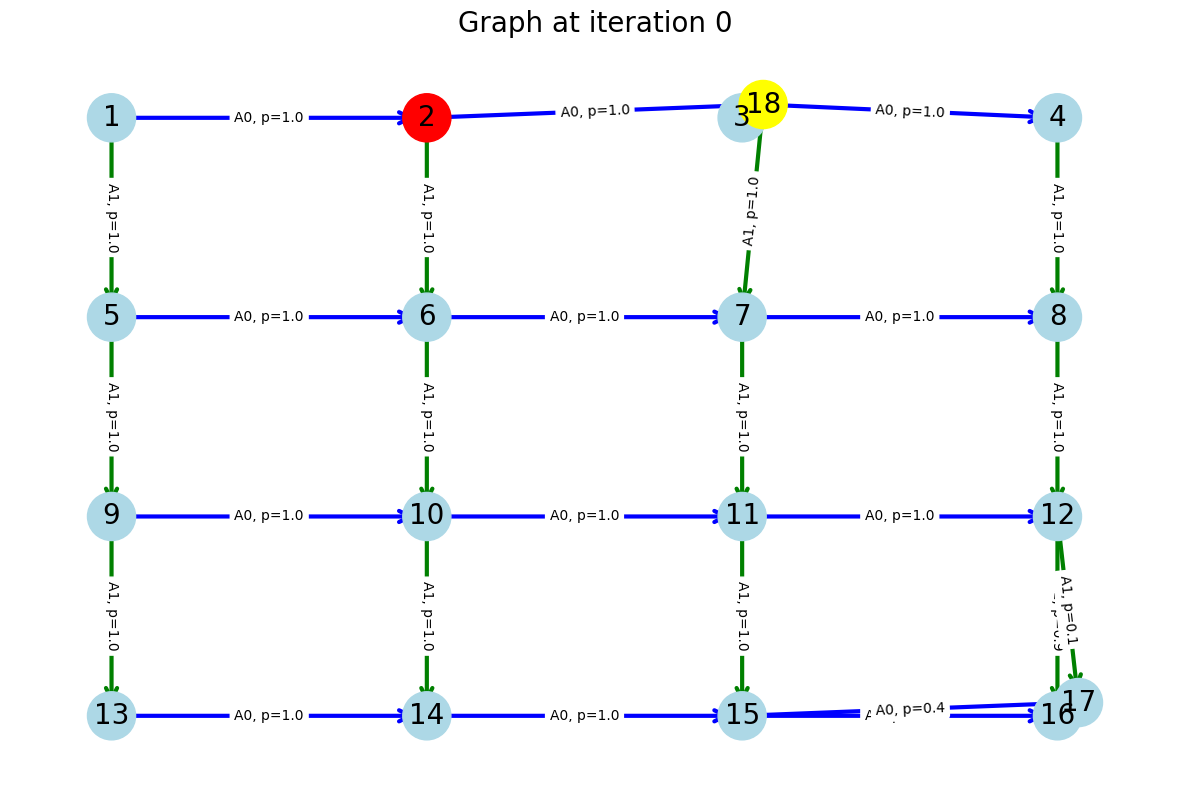

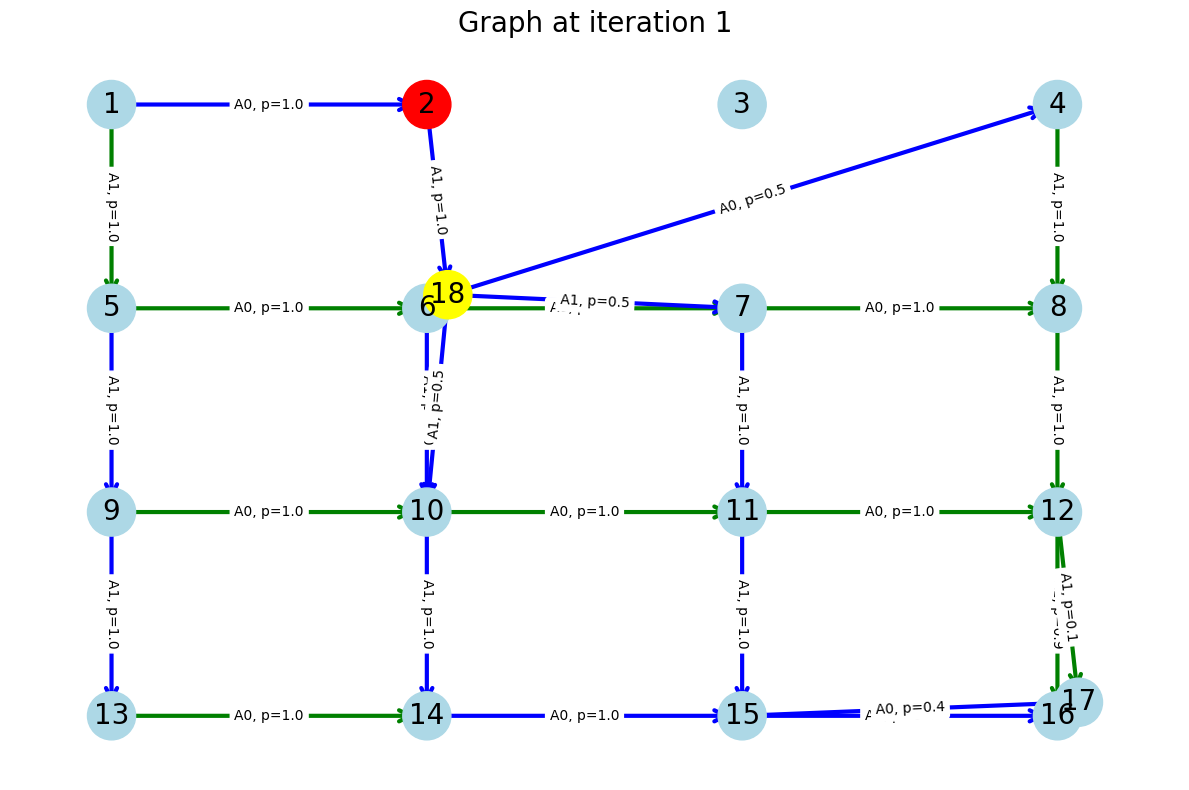



Iteration 1
Stochastic pairs: (12, 1)
state 1 has a value 229 and b value 15 leading to a/(a+b) = 0.9385245901639344
state 2 has a value 159 and b value 0 leading to a/(a+b) = 1.0
state 4 has a value 63 and b value 0 leading to a/(a+b) = 1.0
state 5 has a value 70 and b value 15 leading to a/(a+b) = 0.8235294117647058
state 6 has a value 70 and b value 0 leading to a/(a+b) = 1.0
state 7 has a value 138 and b value 0 leading to a/(a+b) = 1.0
state 8 has a value 159 and b value 0 leading to a/(a+b) = 1.0
state 9 has a value 0 and b value 15 leading to a/(a+b) = 0.0
state 10 has a value 28 and b value 15 leading to a/(a+b) = 0.6511627906976745
state 11 has a value 70 and b value 15 leading to a/(a+b) = 0.8235294117647058
state 12 has a value 70 and b value 15 leading to a/(a+b) = 0.8235294117647058
state 13 has a value 70 and b value 15 leading to a/(a+b) = 0.8235294117647058
state 14 has a value 70 and b value 15 leading to a/(a+b) = 0.8235294117647058
state 15 has a value 70 and b val

AssertionError: 

In [20]:
# Dataset
env = GridEnvRightDownNoSelf(cue_states=[2,6])
# env = GridEnvRightDownNoSelf(cue_states=[6])

n_episodes = 500
max_steps_per_episode = 10

dataset = generate_dataset(env, n_episodes, max_steps_per_episode)
transition_counts = TM(dataset)
denominators = transition_counts.sum(axis=2, keepdims=True)
denominators[denominators == 0] = 1
transition_probs = transition_counts / denominators
# denominators.shape
actions = [0,1]
iterations=10
used_cues = []
# clone_map = []
clone_dict = {}
reverse_clone_dict = {}
graphiter = 0
savename='cued'
env.plot_graph(transition_probs,'initial',savename=savename)  
# Actual code
for i in range(iterations):
    print("Iteration {}".format(i))
    entropies = compute_transition_entropies(transition_probs)
    stochastic_pairs = find_stochastic_state_actions_by_entropy(entropies, eps=1e-9) # (s,a,sprime,sprime2)
    
    if stochastic_pairs: 
        cues = []
        for (s, a) in stochastic_pairs:
            print("Stochastic pairs: {}".format((s,a)))
            # if len(vali)
            # valid_actions = env.get_valid_actions(s)
            sprime, sprime2 = get_successor_states(transition_counts,s,a)
            cue = calculate_contingency(dataset, s, sprime, sprime2)
            print(cue)
            cues.append(cue)
            
        # split out the successor states
        unique_cues = np.unique([x for sublist in cues for x in sublist])
        split = False
        
        for cue in unique_cues:
            if cue in used_cues: 
                continue
            if split == True: 
                continue
            if cue > 17:
                print("Current cue: {} (clone of {})".format(cue, clone_dict[cue]))
            else:
                print("Current cue: {}".format(cue))
            
            # if cue not in used_cues:
            split=True # just split one at a time
            # valid actions
            # valid_actions = env.get_valid_actions(cue)
            # for a in valid_actions:  
            if cue > env.num_unique_states: #17: # cloned state, so need to get the valid actions from the original state
                valid_actions = env.get_valid_actions(clone_dict[cue])
            else:
                valid_actions = env.get_valid_actions(cue)
            # clone_orig = clone_dict[]
            for a in valid_actions:
                # print(cue,a)
                successor = get_successor_states(transition_counts,cue,a)[0] # suppose 7
                # if reverse_clone_dict[successor]: # this has been created before
                if successor in reverse_clone_dict:
                    existing_clone = reverse_clone_dict[successor]
                    for d, seq in enumerate(dataset):
                        states_seq = seq[0]
                        if has_state(states_seq, successor): # get all the sequence that has 7
                            if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                # 1. modify dataset

                                dataset[d][0] = [existing_clone if x==successor else x for x in dataset[d][0]] 

                else:    # hasn't been created before. split        
                    # split this as a function of whether it came from cue (6) vs. others
                    # has_state(sequence,)
                    n_unique_states = len(get_unique_states(dataset))
                    new_clone = n_unique_states + 1            
                    
                    # clone_map.append((successor,new_clone))
                    clone_dict[new_clone] = successor
                    reverse_clone_dict[successor] = new_clone
                    for d, seq in enumerate(dataset):
                        states_seq = seq[0]
                        if has_state(states_seq, successor): # get all the sequence that has 7
                            if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                # 1. modify dataset

                                dataset[d][0] = [new_clone if x==successor else x for x in dataset[d][0]] 
                # 2. modify transition count
                transition_counts = TM(dataset)
                denominators = transition_counts.sum(axis=2, keepdims=True)
                denominators[denominators == 0] = 1
                transition_probs = transition_counts / denominators
                # graphiter = 0
                env.plot_graph(transition_probs,graphiter, cue, new_clone,savename=savename)
                graphiter+=1
            used_cues.append(cue)
    
        print('\n')
    else:
        print('Finished splitting at iteration {}'.format(i))
        break        
env.plot_graph(transition_probs,'final', savename=savename)    

In [9]:
# Dataset
env = GridEnvDivergingSingleReward(cue_state=6)

n_episodes = 500
max_steps_per_episode = 10

dataset = generate_dataset(env, n_episodes, max_steps_per_episode)
transition_counts = TM(dataset)
denominators = transition_counts.sum(axis=2, keepdims=True)
denominators[denominators == 0] = 1
transition_probs = transition_counts / denominators
# denominators.shape
actions = [0,1]
iterations=10
used_cues = []
# clone_map = []
clone_dict = {}
reverse_clone_dict = {}
graphiter = 0
savename='cued'
plot_graph(transition_probs,'initial',savename=savename)  
# Actual code
for i in range(iterations):
    print("Iteration {}".format(i))
    # figure out which transitions are highly stochastic
    entropies = compute_transition_entropies(transition_probs)
    stochastic_pairs = find_stochastic_state_actions_by_entropy(entropies, eps=1e-9) # (s,a,sprime,sprime2)
    if stochastic_pairs: 
        cues = []
        for (s, a) in stochastic_pairs:
            print("Stochastic pairs: {}".format((s,a)))
            # if len(vali)
            # valid_actions = env.get_valid_actions(s)
            tmp = get_successor_states(transition_counts,s,a)
            print(tmp)
            sprime, sprime2 = tmp

            print(f"successor states: {sprime}, {sprime2}")

            cue = calculate_contingency(dataset, s, sprime, sprime2)
            # print(cue)
            cues.append(cue)
            
        # split out the successor states
        unique_cues = np.unique([x for sublist in cues for x in sublist])
        split = False
        
        for cue in unique_cues:
            if cue in used_cues: 
                continue
            if split == True: 
                continue
            if cue > 17:
                print("Current cue: {} (clone of {})".format(cue, clone_dict[cue]))
            else:
                print("Current cue: {}".format(cue))
            
            # if cue not in used_cues:
            split=True # just split one at a time
            # valid actions
            # valid_actions = env.get_valid_actions(cue)
            # for a in valid_actions:  
            if cue > 17: # cloned state, so need to get the valid actions from the original state
                valid_actions = env.get_valid_actions(clone_dict[cue])
            else:
                valid_actions = env.get_valid_actions(cue)
            # clone_orig = clone_dict[]
            for a in valid_actions:
                # print(cue,a)
                successor = get_successor_states(transition_counts,cue,a)[0] # suppose 7
                print(f"successor of cue {cue} is {successor}")
                # if reverse_clone_dict[successor]: # this has been created before
                if successor in reverse_clone_dict and reverse_clone_dict:
                    existing_clone = reverse_clone_dict[successor]
                    for d, seq in enumerate(dataset):
                        states_seq = seq[0]
                        if has_state(states_seq, successor): # get all the sequence that has 7
                            if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                # 1. modify dataset

                                dataset[d][0] = [existing_clone if x==successor else x for x in dataset[d][0]] 

                else:    # hasn't been created before. split        
                    # split this as a function of whether it came from cue (6) vs. others
                    # has_state(sequence,)
                    print(2)
                    n_unique_states = env.num_unique_states
                    new_clone = n_unique_states + 1   

                    # update the num of new states
                    env.num_unique_states = new_clone

                    print(f"new clone {new_clone} created")         
                    
                    # clone_map.append((successor,new_clone))
                    clone_dict[new_clone] = successor
                    reverse_clone_dict[successor] = new_clone
                    for d, seq in enumerate(dataset):
                        states_seq = seq[0]
                        if has_state(states_seq, successor): # get all the sequence that has 7
                            if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                # 1. modify dataset

                                dataset[d][0] = [new_clone if x==successor else x for x in dataset[d][0]] 
                # 2. modify transition count
                transition_counts = TM(dataset)
                denominators = transition_counts.sum(axis=2, keepdims=True)
                denominators[denominators == 0] = 1
                transition_probs = transition_counts / denominators
                # graphiter = 0
                plot_graph(transition_probs,graphiter, cue, new_clone,savename=savename)
                graphiter+=1
            used_cues.append(cue)
    
        print('\n')
    else:
        print('Finished splitting at iteration {}'.format(i))
        break        
plot_graph(transition_probs,'final', savename=savename)    

NameError: name 'GridEnvDivergingSingleReward' is not defined

# Dataset with no cue (just stochastic transition to 16 or 17)


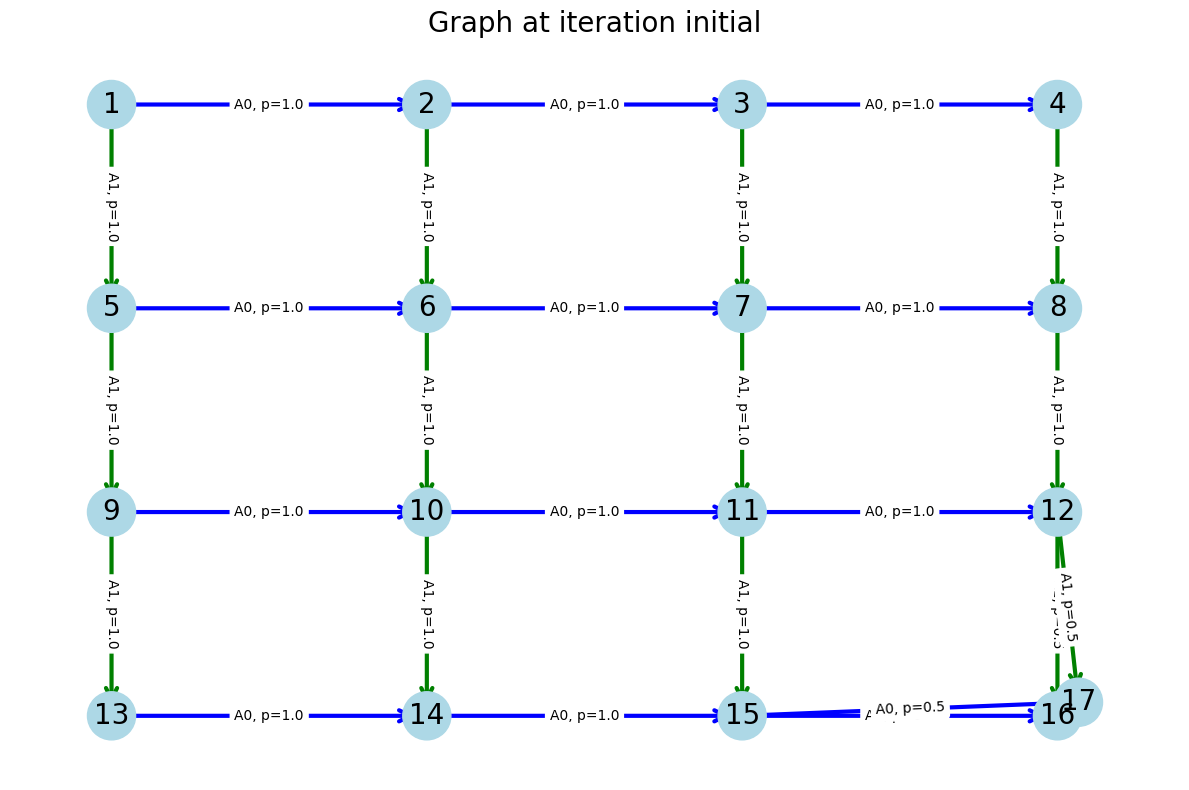

Iteration 0
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 1
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 2
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 3
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 4
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 5
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 6
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 7
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 8
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]


Iteration 9
Stochastic pairs: (12, 1)
[]
Stochastic pairs: (15, 0)
[]




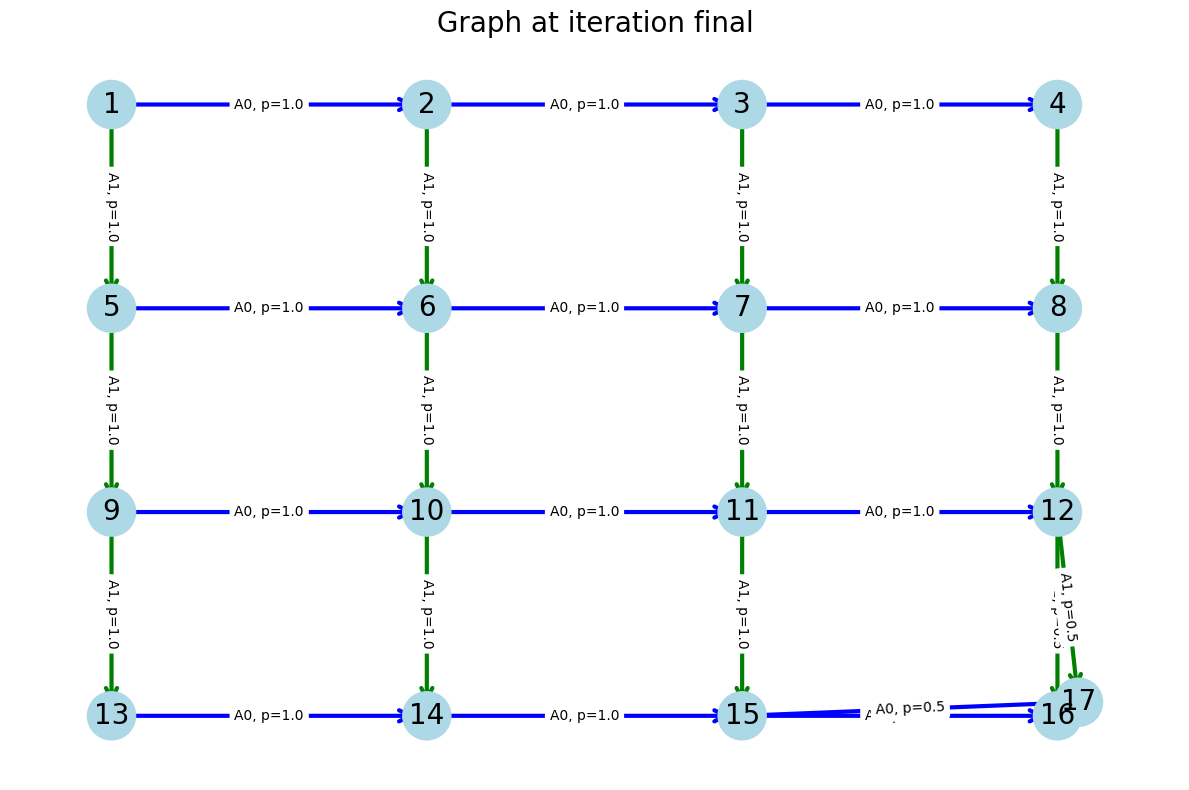

In [34]:
# Dataset
env = GridEnvRightDownNoCue()

n_episodes = 500
max_steps_per_episode = 10

dataset = generate_dataset(env, n_episodes, max_steps_per_episode)
transition_counts = TM(dataset)
denominators = transition_counts.sum(axis=2, keepdims=True)
denominators[denominators == 0] = 1
transition_probs = transition_counts / denominators
# denominators.shape
actions = [0,1]
iterations=10
used_cues = []
# clone_map = []
clone_dict = {}
reverse_clone_dict = {}
graphiter = 0
savename = 'nocue'
plot_graph(transition_probs,'initial',savename=savename)  
# Actual code
for i in range(iterations):
    print("Iteration {}".format(i))
    entropies = compute_transition_entropies(transition_probs)
    stochastic_pairs = find_stochastic_state_actions_by_entropy(entropies, eps=1e-9) # (s,a,sprime,sprime2)
    
    if stochastic_pairs: 
        cues = []
        for (s, a) in stochastic_pairs:
            print("Stochastic pairs: {}".format((s,a)))
            # if len(vali)
            # valid_actions = env.get_valid_actions(s)
            sprime, sprime2 = get_successor_states(transition_counts,s,a)
            cue = calculate_contingency(dataset, s, sprime, sprime2)
            print(cue)
            cues.append(cue)
            
        # split out the successor states
        unique_cues = np.unique([x for sublist in cues for x in sublist])
        split = False
        
        for cue in unique_cues:
            if cue in used_cues: 
                continue
            if split == True: 
                continue
            if cue > 17:
                print("Current cue: {} (clone of {})".format(cue, clone_dict[cue]))
            else:
                print("Current cue: {}".format(cue))
            
            # if cue not in used_cues:
            split=True # just split one at a time
            # valid actions
            # valid_actions = env.get_valid_actions(cue)
            # for a in valid_actions:  
            if cue > 17: # cloned state, so need to get the valid actions from the original state
                valid_actions = env.get_valid_actions(clone_dict[cue])
            else:
                valid_actions = env.get_valid_actions(cue)
            # clone_orig = clone_dict[]
            for a in valid_actions:
                # print(cue,a)
                successor = get_successor_states(transition_counts,cue,a)[0] # suppose 7
                # if reverse_clone_dict[successor]: # this has been created before
                if successor in reverse_clone_dict:
                    existing_clone = reverse_clone_dict[successor]
                    for d, seq in enumerate(dataset):
                        states_seq = seq[0]
                        if has_state(states_seq, successor): # get all the sequence that has 7
                            if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                # 1. modify dataset

                                dataset[d][0] = [existing_clone if x==successor else x for x in dataset[d][0]] 

                else:    # hasn't been created before. split        
                    # split this as a function of whether it came from cue (6) vs. others
                    # has_state(sequence,)
                    n_unique_states = len(get_unique_states(dataset))
                    new_clone = n_unique_states + 1            
                    
                    # clone_map.append((successor,new_clone))
                    clone_dict[new_clone] = successor
                    reverse_clone_dict[successor] = new_clone
                    for d, seq in enumerate(dataset):
                        states_seq = seq[0]
                        if has_state(states_seq, successor): # get all the sequence that has 7
                            if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                # 1. modify dataset

                                dataset[d][0] = [new_clone if x==successor else x for x in dataset[d][0]] 
                # 2. modify transition count
                transition_counts = TM(dataset)
                denominators = transition_counts.sum(axis=2, keepdims=True)
                denominators[denominators == 0] = 1
                transition_probs = transition_counts / denominators
                # graphiter = 0
                plot_graph(transition_probs,graphiter, cue, new_clone,savename=savename)
                graphiter+=1
            used_cues.append(cue)
    
        print('\n')
    else:
        print('Finished splitting at iteration {}'.format(i))
        break        
plot_graph(transition_probs,'final',savename=savename)    

# Splitter cell experiment

In [49]:
def plot_graph_nogrid(T, niter, highlight_node=0, highlight_node_2=0, save=True, savename='nogrid'):
    # plot_graph_nogrid(transition_probs,graphiter, cue, new_clone,savename=savename)
    # transition_probs,graphiter, cue, new_clone,savename=savename
    n_state = np.shape(T)[0]
    n_action = np.shape(T)[1]
    # T = np.random.rand(n_state, n_action, n_state)
    # Normalize so that each [s,a,:] sums to 1 (like proper probabilities)
    # for s in range(n_state):
    #     for a in range(n_action):
    #         T[s, a, :] /= T[s, a, :].sum()

    # Initialize a directed graph
    G = nx.DiGraph()

    # Add edges
    for s in range(n_state):
        for a in range(n_action):
            for s_next in range(n_state):
                prob = T[s, a, s_next]
                if prob > 0:
                    # You can store an edge label that contains the action 
                    # and probability.
                    G.add_edge(
                        f"S{s}", f"S{s_next}", 
                        label=f"A{a}, p={prob:.2f}"
                    )
    # Create a color list; default 'lightblue', but 'red' for special_node
    colors = []
    for node in G.nodes():
        if node == highlight_node:
            colors.append("red")
        elif node == highlight_node_2:
            colors.append("yellow")
        else:
            colors.append("lightblue")
    # Layout the graph
    pos = nx.spring_layout(G, seed=42)  # you can choose any layout

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=1500, node_color=colors)
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black')
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15)

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.axis('off')
    plt.title("Iteration {}".format(niter))
    plt.show()


In [50]:
np.shape(transition_probs)[1]

2

In [ ]:
# TODO: Talking points
# - why is there a random extra one?
# - how should the paths for continuous T-Maze be generated - just stop at a certain length or once there is a rewward?
# - should the cue's randomly change for the continuous T-Maze?


In [ ]:
class ContinuousTMaze(Environment):
    """
      3 ----2---- 4
       \    |    /
        \   |   /
         \  |  /
           \|/
            1
    """
    def __init__(self):
        super().__init__()
        self.num_unique_states = 4 # hard coded for now

        # Special states
        self.start_state = 1
        self.current_state = self.start_state

        self.current_cue = None  # can be either 1 or 0 - changes which side has reward

    def reset(self):
        self.current_state = self.start_state
        self.visited_cue = False
        return self.current_state

    def get_valid_actions(self, state=None):
        if state == 1 or state == 3 or state == 4:
            return 1
        elif state == 2:
            return [0, 1]
        else:
            return None

    def step(self, action):
        reward = 0
        if self.current_state == 1:  # only forward - don't even check other moves
            self.current_state = 2
        elif self.current_state == 3 or self.current_state == 4:  # only forward - don't even check other moves
            self.current_state = 1

        elif self.current_state == 2:  # left or right
            if action == 0:  # left
                self.current_state == 3

                if self.current_cue == 1:  # TODO: CHANGE THIS
                    reward += 1
            elif action == 1:  # right
                self.current_state = 4

                if self.current_cue == 0:   # TODO: CHANGE THIS - maybe stopping rule somewhere in here?
                    reward += 1
            else:
                raise ValueError(f"Action {action} is not valid from state {self.current_state}.") 

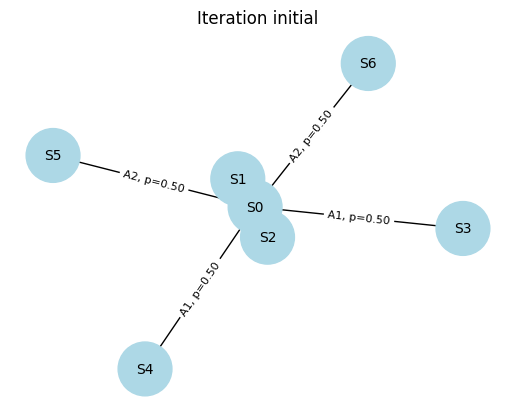

Iteration 0
Stochastic pairs: (0, 1)
[np.int64(1), np.int64(3)]
Stochastic pairs: (0, 2)
[np.int64(2), np.int64(5)]
[1 2 3 5]
Current cue: 1


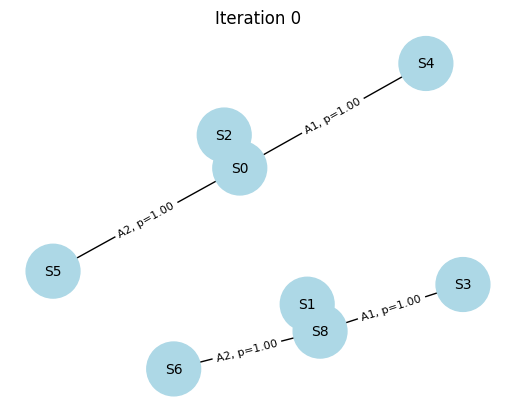



Iteration 1
Finished splitting at iteration 1


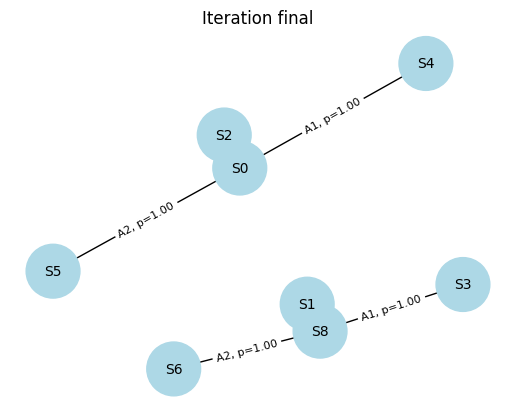

In [51]:
observation_1 = [1,0,3] # start 1, left turn, rewarded
observation_2 = [2,0,5] # start 2, right turn, rewarded
observation_3 = [1,0,6] # start 1, right turn, no reward
observation_4 = [2,0,4] # start 2, left turn, no reward
# 2: left turn, 4: right turn, 5: reward, 6: no reward
actions_1 = [0,1]
actions_2 = [0,2]
actions_3 = [0,2]
actions_4 = [0,1]
n_data = 100 #25
super_observations = np.array(([observation_1] * n_data) +
                          ([observation_2] * n_data) +
                          ([observation_3] * n_data) +
                          ([observation_4] * n_data))
# np.random.shuffle(super_observations)
# Build super_actions with the same structure
super_actions = np.array(([actions_1] * n_data) +
                         ([actions_2] * n_data) +
                         ([actions_3] * n_data) +
                         ([actions_4] * n_data))

# We now have 100 rows in each (25 x 4 = 100).
# Shuffle them in the *same* order using a random permutation of indices
permutation = np.random.permutation(len(super_observations))

# Apply the permutation to both arrays
super_observations = super_observations[permutation]
super_actions = super_actions[permutation]
dataset=[]
for l in range(len(super_observations)):
    dataset.append([super_observations[l], super_actions[l]])



transition_counts = TM(dataset)
denominators = transition_counts.sum(axis=2, keepdims=True)
denominators[denominators == 0] = 1
transition_probs = transition_counts / denominators
# denominators.shape
actions = [0,1,2]
iterations=20
used_cues = []
# clone_map = []
clone_dict = {}
reverse_clone_dict = {}
graphiter = 0
savename='tmaze'
plot_graph_nogrid(transition_probs,'initial',savename=savename)  
# Actual code
for i in range(iterations):
    print("Iteration {}".format(i))
    entropies = compute_transition_entropies(transition_probs)
    stochastic_pairs = find_stochastic_state_actions_by_entropy(entropies, eps=1e-9) # (s,a,sprime,sprime2)
    
    if stochastic_pairs: 
        cues = []
        for (s, a) in stochastic_pairs:
            print("Stochastic pairs: {}".format((s,a)))
            # if len(vali)
            # valid_actions = env.get_valid_actions(s)
            sprime, sprime2 = get_successor_states(transition_counts,s,a)
            cue = calculate_contingency_tmaze(dataset, s, sprime, sprime2)
            print(cue)
            cues.append(cue)
            
        # split out the successor states
        unique_cues = np.unique([x for sublist in cues for x in sublist])
        print(unique_cues)
        split = False
        
        for cue in unique_cues:
            if cue in used_cues: 
                continue
            if split == True: 
                continue
            if cue > 6:
                print("Current cue: {} (clone of {})".format(cue, clone_dict[cue]))
            else:
                print("Current cue: {}".format(cue))
            
            # if cue not in used_cues:
            split=True # just split one at a time
            # valid actions
            # valid_actions = env.get_valid_actions(cue)
            # for a in valid_actions:  
            # if cue > 6: # cloned state, so need to get the valid actions from the original state
            #     valid_actions = env.get_valid_actions(clone_dict[cue])
            # else:
            #     valid_actions = env.get_valid_actions(cue)
            # clone_orig = clone_dict[]
            for a in actions:
                # print(cue,a)
                if get_successor_states(transition_counts,cue,a).size>0:
                    successor = get_successor_states(transition_counts,cue,a)[0] # suppose 7
                    # if reverse_clone_dict[successor]: # this has been created before
                    if successor in reverse_clone_dict:
                        existing_clone = reverse_clone_dict[successor]
                        for d, seq in enumerate(dataset):
                            states_seq = seq[0]
                            if has_state(states_seq, successor): # get all the sequence that has 7
                                if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                    # 1. modify dataset

                                    dataset[d][0] = [existing_clone if x==successor else x for x in dataset[d][0]] 

                    else:    # hasn't been created before. split        
                        # split this as a function of whether it came from cue (6) vs. others
                        # has_state(sequence,)
                        n_unique_states = len(get_unique_states(dataset))
                        new_clone = n_unique_states + 1            
                        
                        # clone_map.append((successor,new_clone))
                        clone_dict[new_clone] = successor
                        reverse_clone_dict[successor] = new_clone
                        for d, seq in enumerate(dataset):
                            states_seq = seq[0]
                            if has_state(states_seq, successor): # get all the sequence that has 7
                                if has_transition(cue, successor,states_seq): # this is sequence that 6->7, clone 7
                                    # 1. modify dataset

                                    dataset[d][0] = [new_clone if x==successor else x for x in dataset[d][0]] 
                    # 2. modify transition count
                    transition_counts = TM(dataset)
                    denominators = transition_counts.sum(axis=2, keepdims=True)
                    denominators[denominators == 0] = 1
                    transition_probs = transition_counts / denominators
                    # graphiter = 0
                    plot_graph_nogrid(transition_probs,graphiter, cue, new_clone,savename=savename)
                    graphiter+=1
            used_cues.append(cue)
    
        print('\n')
    else:
        print('Finished splitting at iteration {}'.format(i))
        break        
plot_graph_nogrid(transition_probs,'final', savename=savename)    

In [69]:
get_successor_states(transition_counts,cue,a)

array([0])

In [64]:
transition_counts[4,0]

array([  0,   0,   0,   0,   0, 100, 100,   0,   0])

In [82]:
get_successor_states(transition_counts,1,0)

array([0])